In [44]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Predict a chest disease

This project started with trying to recreate the ChestXNet project. Briefly explained, the ChestXNet group has developed an algorithm to classify pneumonia from other thoracic diseases in the ChestX-ray14 data set released by Wang et al. (2017). This data set contains of 112,120 frontal-view chest X-ray images, where each of them are labeled with up to 14 different diseases. You can read more about the CheXNet here: https://stanfordmlgroup.github.io/projects/chexnet/
<br>

Some of the issues I encountered along the way with this paper was that they have not described how they have balanced pneumonia in relation to all other diseases, how they have handled image of the same patient in the training and the validation sets, and how their test set looks like.
<br>

Therefore, it has been difficult for me to compare this project with theirs.
The purpose of recreating their project was to use a trained network on chest X ray14 data set to train another x-ray data set and look into the value of transfer learning.
To achieve a well trained network on chestX-ray 14 data set we have decided to look into another disease with more unique examples in the dataset compared with pneumonia.

In [45]:
import sys
sys.path.append("../../fastai/")

In [46]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [47]:
PATH = "/home/sathiesh/Deep_Learning_Kaliy/my_projects/chest-xrays/data/"  #MMIV
#PATH = "/Users/Sathiesh/MachineLearning/Deep_Learning_Kaliy/my_projects/chest-xrays/data/" #Home

In [48]:
sz=112
arch=dn121 
bs = 16

In [49]:
label_csv = f'{PATH}Data_Entry_2017.csv' 

In [50]:
os.listdir(PATH)

['models',
 'tmp',
 'labels.csv',
 'train',
 'train_contrast',
 'Data_Entry_2017.csv',
 'test_list.txt',
 'cleaned_labels']

In [51]:
df = pd.read_csv(label_csv)

# Feature engineering and data cleaning 

Below is a brief information about the required columns from the dataset:
- ###### Image Index: The name of an image
- ###### Finding Labels: Shows the disease(s) 

In [52]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalHeight,OriginalImagePixelSpacingx,OriginalImagePixelSpacingy,Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [53]:
df = df.drop(['Follow-up #','Patient ID', 'Patient Age', 'Patient Gender', 'View Position',
              'OriginalImageWidth', 'OriginalHeight', 'OriginalImagePixelSpacingx', 'OriginalImagePixelSpacingy', 'Unnamed: 11'],axis=1)
df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia


## Top 10 diseases in the dataset


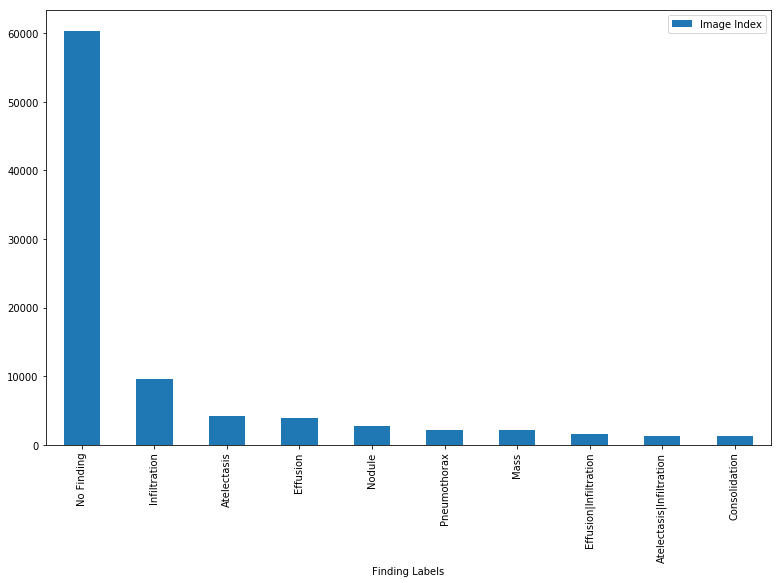

In [54]:
df_sorted = df.pivot_table(index='Finding Labels', aggfunc=len).sort_values('Image Index', ascending=False) 
df_sorted[0:10].plot(kind='bar',figsize=(13,8))

In [55]:
df_sorted.head(10)

,Image Index
Finding Labels,
No Finding,60361
Infiltration,9547
Atelectasis,4215
Effusion,3955
Nodule,2705
Pneumothorax,2194
Mass,2139
Effusion|Infiltration,1603
Atelectasis|Infiltration,1350


## Analyzing a specific disease
If this returns true, then skip to <i> view data</i> section

In [56]:
disease_name = 'Effusion'
cleaned_label_path = f'{PATH}cleaned_labels/{disease_name}.csv' 
os.path.exists(cleaned_label_path)

True

In [29]:
df_disease = df_sorted[df_sorted.index.str.contains(disease_name)]
disease_row = df_sorted.loc[disease_name]['Image Index']
total_apperance = sum(df_disease['Image Index'])
print(disease_name +': ' + str(disease_row) + '\n'+ 'Total apperance: ' + str(total_apperance)+ '\n'
      +'Number of rows that must be deleted: ' + (str)(total_apperance - disease_row))

Effusion: 3955
Total apperance: 13317
Number of rows that must be deleted: 9362


Remove the rows that are combined with one or more of the other diseases.<br>
In this way, we have <i>one diease vs all the others</i>. 

In [30]:
temp_df = df
temp_df['searching_disease'] = temp_df['Finding Labels'].str.contains(disease_name)
temp_df = temp_df[temp_df['searching_disease']]; #all rows with disease_name 

#TODO find another way to do this
temp_df['Finding Labels'] = temp_df['Finding Labels'].str.replace('|','REMOVE')
temp_df['searching_disease'] = temp_df['Finding Labels'].str.contains('REMOVE')
arr = np.array(temp_df[temp_df['searching_disease']].index) #labeled as disease_name + another disease
arr.size 

/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


9362

Remove all indexes that have <b> disease_name</b> + another disease from the dataframe. 

In [31]:
df = df.drop(arr)
df = df.reset_index(drop=True)

### Ratio
Find the ratio to balance the data

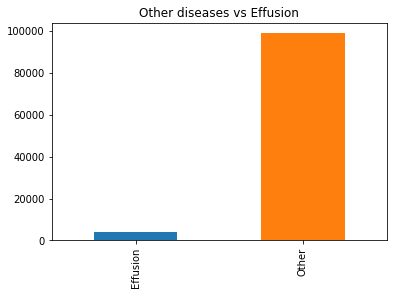

In [32]:
df_sorted = df.pivot_table(index='searching_disease', aggfunc=len).sort_values('Image Index') 
df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Other diseases vs "+disease_name)

In [33]:
df_sorted

,Finding Labels,Image Index
Effusion,3955,3955
Other,98803,98803


In [34]:
disease_count = df_sorted['Image Index'][0]
other_disease_count = df_sorted['Image Index'][1]
ratio = (other_disease_count// disease_count)-1
df = df.append([df[df.searching_disease]]*ratio, ignore_index=True) #df.searching_disease: array m true, false 
ratio

23

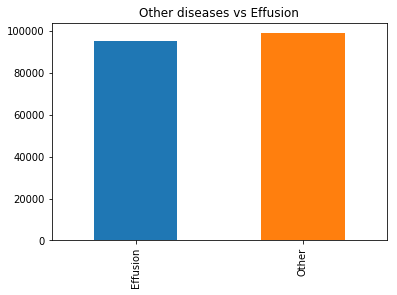

In [35]:
df_sorted = df.pivot_table(index='searching_disease', aggfunc=len).sort_values('Image Index') 
df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Other diseases vs "+disease_name)

The validation set we create with the training set may contain images of the same patient as there are several images of a patient. This may lead to better results on the validation set than on test set. 
Since we want a well trained network on chestX-ray 14 data set to look into the value of transfer learning, we have decided to use the test set as the validation set. 

In [36]:
val_image_name_list = [line.rstrip('\n') for line in open(f'{PATH}test_list.txt')]
len(val_image_name_list),val_image_name_list[:5]

(25596,
 ['00000003_000.png',
  '00000003_001.png',
  '00000003_002.png',
  '00000003_003.png',
  '00000003_004.png'])

The indexes of all the images that should be in the validation set

In [37]:
val_idxs = df[df['Image Index'].isin(val_image_name_list)].index 
len(val_idxs)

48946

In [38]:
print('validation set: ' +str(len(val_idxs)/df.index.size) +'%')

validation set: 0.2526597254843256%


In [39]:
df = df.drop(['Finding Labels'], axis=1)

In [40]:
df.head()

,Image Index,searching_disease
0,00000001_000.png,False
1,00000001_001.png,False
2,00000002_000.png,False
3,00000003_000.png,False
4,00000003_001.png,False


In [41]:
cleaned_label_path = f'{PATH}/cleaned_labels/{disease_name}.csv'
df.to_csv(cleaned_label_path, index=False)

# View data 

In [57]:
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=RandomFlip())  
    return ImageClassifierData.from_csv(PATH, 'train_contrast', cleaned_label_path, test_name=None,
                                       val_idxs=val_idxs, tfms=tfms, bs=bs);

In [60]:
data = get_data(sz)

In [62]:
fn = PATH+data.trn_ds.fnames[0]
fn 

'/home/sathiesh/Deep_Learning_Kaliy/my_projects/chest-xrays/data/train_contrast/00000001_000.png'

In [63]:
data.trn_ds.fnames.shape ,data.val_ds.fnames.shape

((144777,), (48946,))

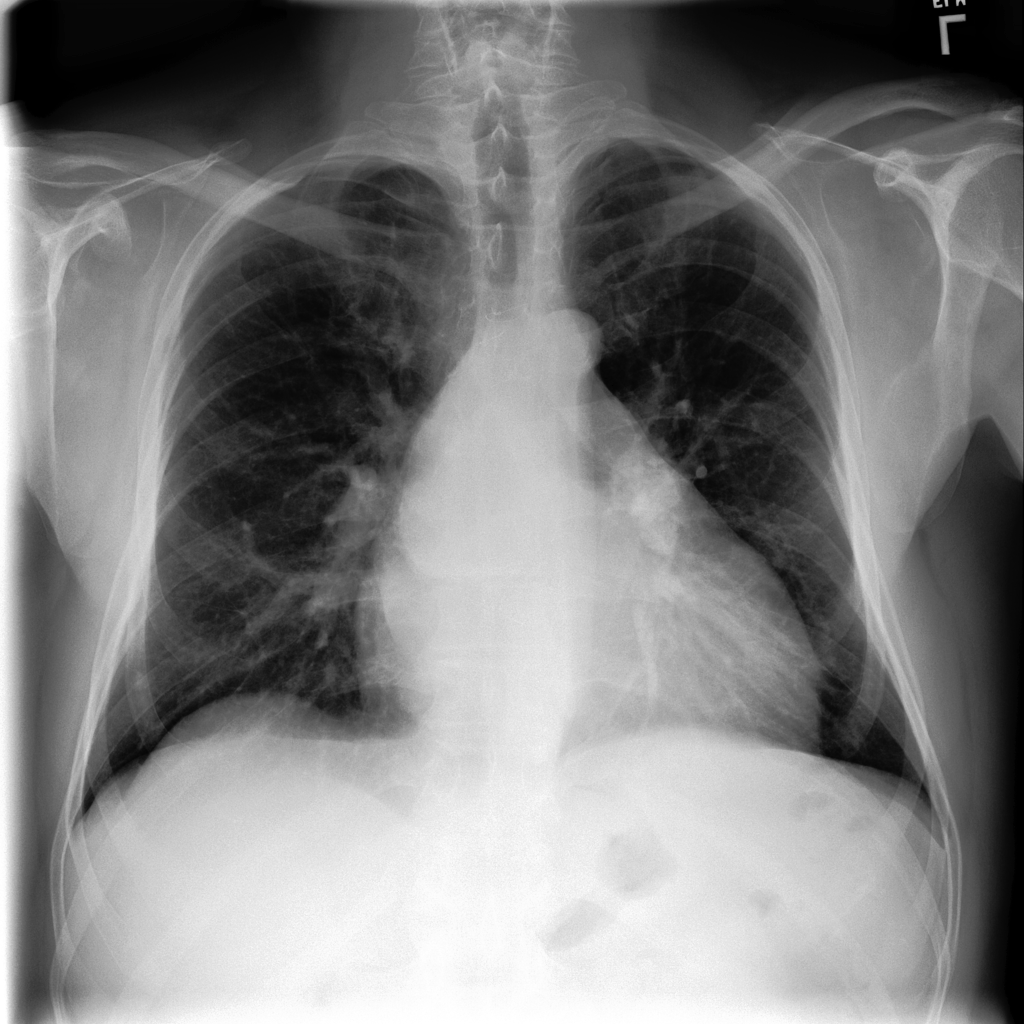

In [64]:
img = PIL.Image.open(fn);
img

In [65]:
img.size

(1024, 1024)

In [66]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames} #størrelsene på alle bildene 

In [67]:
row_sz, col_sz = list(zip(*size_d.values())) #skjønne hva denne gjør

In [68]:
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

In [69]:
row_sz

array([1024, 1024, 1024, ..., 1024, 1024, 1024])

(array([    0.,     0.,     0.,     0.,     0., 78089.,     0.,     0.,     0.,     0.]),
 array([1023.5, 1023.6, 1023.7, 1023.8, 1023.9, 1024. , 1024.1, 1024.2, 1024.3, 1024.4, 1024.5]),
 <a list of 10 Patch objects>)

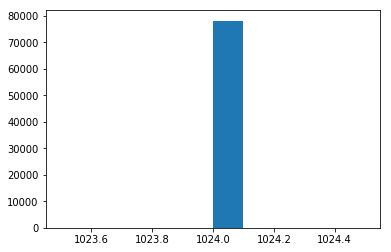

In [70]:
plt.hist(row_sz)

In [71]:
data.classes[:2]

['False', 'True']

# Training

In [72]:
learn = ConvLearner.pretrained(arch, data, ps = 0.5)

In [41]:
#learn.lr_find()

In [42]:
#learn.sched.plot()

In [43]:
lr = 0.00008

In [44]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                       
    0      0.622696   0.562893   0.71489   
    1      0.596627   0.552835   0.723713                       
    2      0.597112   0.547751   0.729044                       
    3      0.570686   0.539668   0.728942                       
    4      0.566201   0.537364   0.734988                       
    5      0.579272   0.536689   0.737868                       
    6      0.580557   0.534968   0.736111                       



[0.534968109652887, 0.7361111111111112]

In [73]:
#learn.lr_find()
#learn.sched.plot()

In [47]:
learn.unfreeze()

In [48]:
lrs = [lr/9, lr/3,lr];

In [49]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.527785   0.505015   0.758333  
    1      0.488734   0.476442   0.779065                      
    2      0.467262   0.465358   0.786356                      
    3      0.442713   0.435574   0.803411                      
    4      0.408699   0.410735   0.816912                      
    5      0.390498   0.398759   0.824163                      
    6      0.405658   0.392475   0.829432                      



[0.39247476074576765, 0.8294321895424837]

In [53]:
learn.save(f'{sz}') 

In [ ]:
learn.lr_find()
learn.sched.plot()

In [54]:
sz=224 #kanskje gjøre denne litt mindre 

In [55]:
learn.set_data(get_data(sz))
learn.freeze() 
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) 

epoch      trn_loss   val_loss   accuracy                      
    0      0.574441   0.549821   0.728084  
    1      0.556925   0.535721   0.738174                      
    2      0.557209   0.529901   0.748121                      
    3      0.562433   0.525314   0.747835                      
    4      0.551265   0.519912   0.752124                      
    5      0.546051   0.518745   0.755229                      
    6      0.540077   0.518249   0.755882                      



[0.5182493073196193, 0.7558823529411764]

In [56]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2) 

epoch      trn_loss   val_loss   accuracy                      
    0      0.475578   0.465027   0.790339  
    1      0.449853   0.432405   0.807618                      
    2      0.431776   0.423915   0.811806                      



[0.42391472074257974, 0.8118055555555556]

In [57]:
learn.save(f'{sz}')

In [58]:
sz = 299

In [59]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.516495   0.463535   0.789726  
    1      0.454578   0.462625   0.787316                      
    2      0.478635   0.460411   0.78942                       
    3      0.478524   0.460692   0.789645                      
    4      0.48676    0.457639   0.790094                      
    5      0.495019   0.457489   0.791197                      
    6      0.471988   0.460194   0.789175                      



[0.4601938216989629, 0.7891748366013072]

In [60]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   accuracy                      
    0      0.461085   0.435572   0.806638  
    1      0.434163   0.41679    0.813583                      
    2      0.40129    0.399543   0.82643                       
    3      0.35848    0.372884   0.846671                      
    4      0.290697   0.347001   0.865278                      
    5      0.269097   0.330164   0.875899                      
    6      0.285213   0.330372   0.876757                      



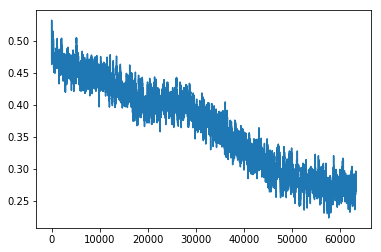

In [61]:
learn.sched.plot_loss()

#  Analyzing the results

In [62]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [63]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [64]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [65]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),axis=0)
accuracy = accuracy_np(probs, y)

0.8818902463939852

In [ ]:
print('Accuracy with TTA: '+str(accuracy))

In [66]:
probs

array([[0.88995, 0.11005],
       [0.85638, 0.14362],
       [0.52782, 0.47218],
       ...,
       [0.99909, 0.00091],
       [0.90372, 0.09628],
       [0.9988 , 0.0012 ]], dtype=float32)

In [67]:
preds = np.argmax(probs, axis=1)  #selects the position of the highest value
#probs = probs[:,1] 

In [68]:
cm = confusion_matrix(y,preds);

[[20788  3757]
 [ 2024 22377]]


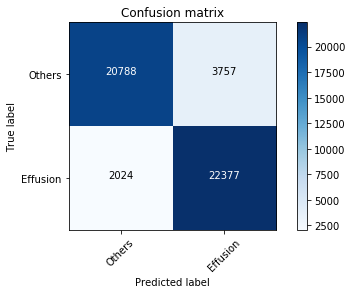

In [71]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect "+str(disease_name))